# pill 3: About performance

**Outline**

+ Accuracy metrics
    + Error and accuracy
    + Receiver operating curve
    + Area under the curve
    
+ Model selection II. Crossvalidation.

+ The unbalanced problem.

+ Confusion matrix and partial performance measurements.




## 1. More about the 'Churn' problem and accuracy metrics.



Modeling churn means to understand what keeps the customer engaged to our product. Its analysis goal is to predict or describe the **churn rate** i.e. the rate at which customer leave or cease the subscription to a service. Its value lies in the fact that engaging new customers is often more costly than retaining existing ones. For that reason subscription business-based companies usually have proactive policies towards customer retention.

In this case study, we aim at building a machine learning based model for customer churn prediction on data from a Telecom company. Each row on the dataset represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

This case is partially inspired in Eric Chiang's analysis of churn rate. Data is available from the University of California Irvine machine learning repositories data set.

The complete set of attributes is the following:

+ State: categorical, for the 50 states and the District of Columbia
+ Account length: integer-valued, how long an account has been active 
+ Area code: categorical
+ Phone number: customer ID
+ International Plan: binary feature, yes or no
+ VoiceMail Plan: binary feature, yes or no
+ Number of voice mail messages: integer-valued
+ Total day minutes: continuous, minutes customer used service during the day
+ Total day calls: integer-valued
+ Total day charge: continuous
+ Total evening minutes: continuous, minutes customer used service during the evening
+ Total evening calls: integer-valued
+ Total evening charge: continuous
+ Total night minutes: continuous, minutes customer used service during the night
+ Total night calls: integer-valued
+ Total night charge: continuous
+ Total international minutes: continuous, minutes customer used service to make international calls
+ Total international calls: integer-valued
+ Total international charge: continuous
+ Number of calls to customer service: integer-valued

In [1]:
from __future__ import division
import pandas as pd
import numpy as np

churn_df = pd.read_csv('./files/churn.csv')
col_names = churn_df.columns.tolist()

print ("Column names:")
print (col_names)

to_show = col_names[:6] + col_names[-6:]

print ("\nSample data:")
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [2]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# We don't need these columns
to_drop = ['State','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.values.astype(np.float)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 18 features
Unique target labels: [0 1]


/tmp/ipykernel_2785/1219425965.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = churn_feat_space.values.astype(np.float)


### 1.1 More about model selection: Cross-validation

We saw in former pills that a nice way of assessing performance or comparing models is simulating the exploitation stage. Remember that this was done splitting the data set in training, validation and test sets. Because this splitting process has a randomness involved the resulting performance metric is also a random varible and the instantaneous value of the variable is heavily affected by the split. It can be the case that the split is very favorable and we get awesome performance metric values, or the other way around. We suggested the posibility of doing this same proces many times to get a good picture of the real behavior of the classifier. This is a perfectly correct way for assessing the performance. However one could argue that some points can be never chosen for testing, or that some points can be shared accross the different training splits. These could bias the result.

Another well founded approach in order to circumvent the former problem is what we call **cross-validation**. The idea behind this process is that each point will be used for testing purposes. The most well known cross-validation techniques are:

+ **Leave one out (LOO)**: Leave one out is as follows,
    + Take one sample of the data set $x_i$.
    + Train the classfier with all the data set except for the data selected $X_{train} = \{X\}\setminus x_i$.
    + Test the classifier on $x_i$ and store the result.
    + Repeat the process for all samples of the data set.
    + At the end of the process you should have an array with all the results ready for the computation of a performance metric.
    
Leave-one-out is computationally intensive, because it requires training a classifier as many times as examples in the data set we have. In order to alleviate this computational burden we can define the following process 

+ **K-fold cross-validation**: 

    + Split the data set in K disjoint subsets with the same cardinality, i.e. $\{X\} = S_1 \cup S_2 \dots \cup S_k$ where $S_i \subset \{X\}$, $S_i \cap S_j = \emptyset,  i\neq j$, and $|S_i|\approx |S_j|,  \forall i, j$.
    + Select one of the subsets $S_i$. This will be used as test set.
    + Train the classfier in all except that subset, i.e. $X_{train} = \{X\} \setminus S_i$.
    + Test the trained classifier with $S_i$ and store the individual results for each sample in the subset (we can also consider the partial performance statistics in the subset for other hint on performance)
    + Repeat for each subset
    + At the end of the process you should have an array with all individual results ready for the computation of a performance metric. 
    
This second approach is subject to some variability in the splitting process. Thus the resulting performance metric is again a random variable. One can repeat this process several times to estimate statistics such as the mean and variance of the classifier. Sometimes you will see partial performance statistics of each fold aggregated as simple way for approximating the process statistics.

Leave one out can be seen as a particular instance of K-fold cross validation with K equal to the cardinality of the data set.

Let us practice this with the churn problem.

In [3]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

cv = model_selection.KFold(n_splits = 3 ,shuffle=True ,random_state=42)
cv.get_n_splits(X)

yhat = np.zeros((X.shape[0],1))
for train_idx, test_idx in cv.split(X):
    X_train,y_train = X[train_idx,:],y[train_idx]
    X_test,y_test = X[test_idx,:],y[test_idx]
    
    scaler = StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    
    clf = RandomForestClassifier(n_estimators = 11)
    clf.fit(X_train_scaled,y_train)
    
    X_test_scaled = scaler.transform(X_test)
    
    yhat[test_idx] = clf.predict(X_test_scaled).reshape(-1,1)
    

In [4]:
from sklearn import metrics

print ('Accuracy score: ' + str(metrics.accuracy_score(yhat,y)))

Accuracy score: 0.9441944194419442


<div class = "alert alert-success" style = "border-radius:10px"><b>EXERCISE:</b> Let us check the performance for different values of `K = {2,3,5,10,20}`. In order to assess the variance of the process let us repeat each cross-validation `50` times. Show a box plot comparing the performances of the three methods.
</div>

In [ ]:
#Your code

In [ ]:
acc.shape

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(121)
plt.boxplot(acc)
plt.gca().set_ylim([0.92,0.98])
plt.title('Using the full set statistic')
plt.subplot(122)
plt.boxplot(partial_acc)
plt.title('Using partial statistics')
plt.gca().set_ylim([0.92,0.98])
plt.gcf().set_size_inches(14,4)

## 2.  Unbalanced datasets and the need for other kind of performance metrics.

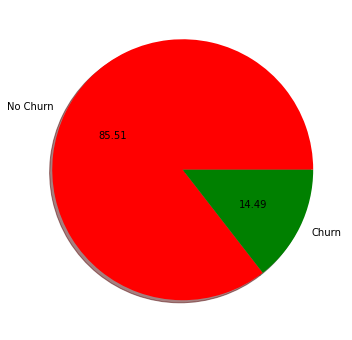

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(np.c_[len(y)-np.sum(y),np.sum(y)][0],labels=['No Churn','Churn'],colors=['r','g'],shadow=True,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)

<div class = "alert alert-info">
**Unbalanced datasets**
<p>
The unbalanced term describes the condition of the data where the ratio between the sizes of the positive and negative is a small value. In those scenarios, always predicting the majority class usually yields good accuracy performance, though it is ill informative. This kind of problems is very common when we want to model unusual events such as rare diseases, the occurrence of a failure in machinery, credit card fraud operations, etc. In those scenarios gathering data from usual events is very easy but collecting data from unusual events is difficult and results in a comparatively small size data set. In order to measure the performance on those data sets one has to use other performance metrics, such as specificity or positive predictive value on the minority class. In the end, the value of a misclassification of a sample depends on the application and the user. For example, in cancer detection because the cost of missing one patient in a trial is very large, we want the predictor to have very large sensitivity (we do not accept false negatives) though it means accepting more false positives. These false positives can be discarded in subsequent tests. 
</div>

### 2.1 The confusion matrix


Although accuracy is the most normal metric for evaluating classifiers, there are cases when the business value of correctly predicting elements from one class is different from the value for the prediction of elements of another class. In those cases, accuracy is not a good performance metric and more detailed analysis is needed. The **confusion matrix** enables us to define different metrics considering such scenarios. The confusion matrix considers the concepts of the classifier outcome and the actual ground truth or gold standard. In a binary problem, there are four possible cases: 


+ *True positives (TP):* When the classifier predicts a sample as positive and it really is positive.
+ *False positives (FP):* When the classifier predicts a sample as positive but in fact it is negative.
+ *True negatives (TN):* When the classifier predicts a sample as negative and it really is negative.
+ *False negatives (FN):* When the classifier predicts a sample as negative but in fact it is positive.


We can summarize this information in a matrix, namely the confusion matrix, as follows:
<img src = "./files/confmat.png" width = 800px>
The combination of these elements allows us to define several performance metrics:


+ *Accuracy:*
$$\text{accuracy}=\frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

+ Column-wise we find these two partial performance metrics:
 + *Sensitivity or Recall:*
$$\text{sensitivity}=\frac{\text{TP}}{\text{Real Positives}}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$
 + *Specificity:*
$$\text{specificity}=\frac{\text{TN}}{\text{Real Negatives}}=\frac{\text{TN}}{\text{TN}+\text{FP}}$$

+ Row-wise we find these two partial performance metrics:}
    + *Precision or Positive Predictive Value:*
$$\text{precision}=\frac{\text{TP}}{\text{Predicted Positives}}=\frac{\text{TP}}{\text{TP}+\text{FP}}$$
    + *Negative predictive value:*
$$\text{NPV}=\frac{\text{TN}}{\text{Predicted Negative}}=\frac{\text{TN}}{\text{TN}+\text{FN}}$$


<div class= "alert alert-danger" style = "border-radius:10px"> **QUIZ:** Consider the following questions and answer accordingly.

</div>

Let us code the confusion matrix and the different metrics for the churn problem:

In [6]:
from sklearn import neighbors
from sklearn import model_selection

clf = neighbors.KNeighborsClassifier(n_neighbors=3)
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3,random_state=42)
clf.fit(X_train,y_train)
yhat = clf.predict(X_test)



In [7]:
TP = np.sum(np.logical_and(yhat==y_test,yhat==1))
TN = np.sum(np.logical_and(yhat==y_test,yhat==0))
FP = np.sum(np.logical_and(yhat!=y_test,yhat==1))
FN = np.sum(np.logical_and(yhat!=y_test,yhat==0))

print (TP,FP)
print (FN,TN)

34 43
109 814


In [8]:
from sklearn import metrics
#I use wikipedia notation, thus we have to swap predictions and groundtruth
print (metrics.confusion_matrix(yhat,y_test))

[[814 109]
 [ 43  34]]


In [9]:
print (metrics.classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       857
           1       0.44      0.24      0.31       143

    accuracy                           0.85      1000
   macro avg       0.66      0.59      0.61      1000
weighted avg       0.82      0.85      0.83      1000



Another interesting metric is *F1-score*. This is defined as follows,

$\text{F1-score} = 2\cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision}+\text{recall}} = 2\frac{\frac{TP}{TP+FP}\frac{TP}{TP+FN}}{\frac{TP}{TP+FP}+\frac{TP}{TP+FN}} = \frac{2 TP}{TP+FN+TP+FP} $

<div class = "alert alert-info" style= "border-radius:10px">**QUESTION:** Why `classification_report` only reports precission and recall?</div>

### 2.2 Operating point, ROC, and Area under the curve

Many classifiers can be considered as thresholded regressors. This means that the actual classifier actually reports some score that has to be further thresholded to finally decide the class. Consider, as an example, a binary classifier that scores the probability of belonging to class 'A', i.e. $P(x \in 'A')$. Obviously, $1 - P(x \in 'A')$ is the probability of belonging to class 'B'. The decision of belonging to class 'A' is given by $P(x \in 'A')>thr$. We usually will use $thr = 0.5$ but we could change this threshold. 

<div class = "alert alert-info" style = "border-radius:10px">**QUESTION:** What is the effect of lowering the value of the threshold in the four partial performance metrics? Consider what happens to the positive samples ('A') and to the negative samples ('B')</div>

This means that we can the amount of true positive and the amount of false positives.This gives rise to the concept of the **operating point**. The operating point is the precise threshold we select for an specific application by controlling the true positive rate (recall) vs the false positive rate (1- specificity = FP / (FP+TN)). We can plot all the operating points by varying the threshold value and ploting the precission versus the recall. This curve is called **Receiver Operating Characteristic**. It shows how the true positive rate changes when the false positive rate change.



 It also means that we can control precision and recall by modifying this threshold. 
 This also allow us to define the **Precision-Recall curve**.

#### 2.2.1 The perfect curve

The ROC curve tells us about the behavior of the positive class, displaying how the true positive rate changes as we change the false positive rate. Note that the curve depends on all the terms of the confusion matrix:


$$TPR = sensitivity \;(recall) = \frac{TP}{TP+FN}$$

$$FPR = 1-specificity = \frac{FP}{TN+FP}$$

<div class = "alert alert-danger" style="border-radius:10px"> **QUIZ** In the case of a perfect classification, what are the values of TPR and FRP ?</div>

#### 2.2.2 Computing the curve

Let us compute the curve. In order to do so we need the score from a classifier. Some classifiers in sklearn have the method `predict_proba` that returns the "confidence" of the classification. Let us do this,

In [10]:
from sklearn import neighbors
from sklearn import model_selection

clf = neighbors.KNeighborsClassifier(n_neighbors=21)
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3,random_state=42)
clf.fit(X_train,y_train)
yhat = clf.predict(X_test)

In [11]:
score = clf.predict_proba(X_test)


In [12]:
score

array([[0.85714286, 0.14285714],
       [0.85714286, 0.14285714],
       [0.9047619 , 0.0952381 ],
       ...,
       [0.80952381, 0.19047619],
       [0.95238095, 0.04761905],
       [0.85714286, 0.14285714]])

In [13]:
TP = np.sum(np.logical_and(yhat==y_test,yhat==1))
TN = np.sum(np.logical_and(yhat==y_test,yhat==0))
FP = np.sum(np.logical_and(yhat!=y_test,yhat==1))
FN = np.sum(np.logical_and(yhat!=y_test,yhat==0))

TPR = TP /(TP+FN)
FPR = FP /(FP+TN)

In [14]:
np.sum(TPR),np.sum(FPR)


(0.16783216783216784, 0.007001166861143524)

In [15]:
idx=np.argsort(score[:,1])

TPR = []
FPR = []
for i in idx:
    yhat = np.where(score[:,1]>score[i,1],1.0,0.0)
    TP = np.sum(np.logical_and(yhat==y_test,yhat==1.))
    TN = np.sum(np.logical_and(yhat==y_test,yhat==0.))
    FP = np.sum(np.logical_and(yhat!=y_test,yhat==1.))
    FN = np.sum(np.logical_and(yhat!=y_test,yhat==0.))

    TPR.append( TP /(TP+FN) )
    FPR.append( FP /(FP+TN) )

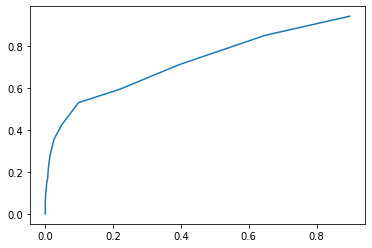

In [16]:
idx = np.argsort(FPR)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.array(FPR)[idx],np.array(TPR)[idx])

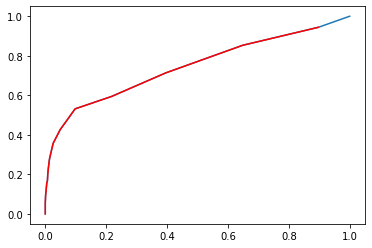

In [17]:
from sklearn import metrics
fpr, tpr,_ = metrics.roc_curve(y_test,score[:,1])
fig = plt.figure()
plt.plot(fpr,tpr)
plt.plot(np.array(FPR)[idx],np.array(TPR)[idx],'r')

He,he! The same result as sklearn ;-)

<div class = "alert alert-info" style = "border-radius:10px">**QUESTION:** What is the operating point?</div>

#### 2.2.3 Area under the curve

The area under the curve is a good value for summarizing the ROC behavior. Although not perfect it gives a good idea for comparing classifiers. Let us compute the Area under the curve using the trapezoid method:

In [18]:
def linear_AUC(tpr,fpr):
    val,idx = np.unique(fpr,return_index = True)
    auc = 0
    N = len(idx)-1 
    for i in range(N):
        auc  = auc + tpr[idx[i]]*(fpr[idx[i+1]]-fpr[idx[i]]) + (tpr[idx[i+1]]-tpr[idx[i]])*(fpr[idx[i+1]]-fpr[idx[i]])/2
    auc = auc + tpr[idx[i+1]]*(1.-fpr[idx[i+1]]) + (1.-tpr[idx[i+1]])*(1.-fpr[idx[i+1]])/2
    return auc

In [19]:
linear_AUC(tpr,fpr)

0.7439229382053185

In [20]:
from sklearn import metrics
metrics.auc(fpr,tpr)

0.7439555776778648

Oh!!!! Awesome, nearly the same ;-)

#### 2.2.4 Comparing classifiers

Let us compare some classifiers in the problem of `Churn?` and check which one works better.

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Compare a linear support vector machine, random forest, `11`-nearest neighbor, and logistic regression in the problem of Churn. 
<ol>
<li>Split data in training and test, `test_size = 0.3`, `random_state = 0`.</li>
<li>Draw in a single plot the four curves.</li>
<li>Compute the area under the curve.</li>
</ol>

**HINT: ** In order to get the confidence/margin in the SVM use the method `decision_function`.
</div>

In [ ]:
#Your code

## 3. The price of confusion matrix

Let us work out a little more the problem of `Churn?`, once again. Consider the following simple business case:

We want to lauch a retention marketing campaing:

+ Each member in the subscription service gives us a profit of $100$ units.
+ The cost of the campaign is $\alpha=10$ units per advertisement.
+ Supose that we only recover $\beta = 10\%$ of the people that received the campaign and were going to churn.
+ We are going to use a classifier to select the targets of the campaign.





<div class = "alert alert-success" style = "border-radius:10px">
**EXERCISE/QUESTION:** Model the former problem in terms of the elements of the confusion matrix. 
</div>


<div class = "alert alert-success" style = "border-radius:10px">
**EXERCISE:** Train a `LogisticRegressor` and check if the campaign is profitable. Use `test_size = 0.3` and `random_state = 31`.
</div>

In [ ]:
#Your code

In [ ]:
TP = c[1,1]
FP = c[1,0]
TN = c[0,0]
FN = c[0,1]

In [ ]:
FN_hand = np.sum(np.logical_and(yhat!=y_test,yhat==0.))

print (FN,FN_hand)

In [ ]:
alpha = 10
beta = 0.1
balance=-alpha*(TP+FP)+beta*TP*100
print (balance)

The campaign is not sustainable as it is.

Let us choose an operating point, so that we maximize the validation profit.

In [ ]:
score = lr.predict_proba(X_test)

idx=np.argsort(score[:,1])

balance_old = -1e10 
max_idx  = 0
b = []
for i in idx:
    yhat = np.where(score[:,1]>score[i,1],1.0,0.0)
    TP = np.sum(np.logical_and(yhat==y_test,yhat==1.))
    TN = np.sum(np.logical_and(yhat==y_test,yhat==0.))
    FP = np.sum(np.logical_and(yhat!=y_test,yhat==1.))
    FN = np.sum(np.logical_and(yhat!=y_test,yhat==0.))
    alpha = 10
    beta = 0.1
    balance=-alpha*(TP+FP)+beta*TP*100
    
    b.append(balance)
    
    if balance > balance_old:
        max_idx = i
        balance_old = balance
    
plt.plot(np.array(b))
score[max_idx,1]
yhat = np.where(score[:,1]>score[max_idx,1],1.0,0.0)
print (metrics.confusion_matrix(yhat,y_test))

The operating point indicates it is not worthwhile to consider a campaign with this kind of classifier. But can we do better?

## 4. Dealing with unbalanced datasets

The greatest problem we are facing is due to the fact we are dealing with unbalanced datasets and the original boundary just depends on that. We can try different things to balance the data set:

+ Under sample the majority class.
+ Over sample the minority class using some kind of data interpolator, for example SMOTE.
+ Use class weights, this is also called cost-sensitive classification.
+ Change the performance metric.
+ Split the majority class in subclasses, then train as many classifiers as subclasses. Each involving one subclasses and the minority class. Then use an aggregation technique.



Let us proceed checking some of these techniques. Let us start with resampling the majority class.

In [21]:
np.sum(y_train)/len(y_train)

0.14573510501500214

In [22]:
pidx = np.where(y_train == 1)[0]
nidx = np.where(y_train == 0)[0]

print (np.sum(y_train))

340


In [23]:
sidx=np.random.randint(0,len(nidx),size=np.sum(y_train))

In [24]:
sidx.shape

(340,)

In [25]:
resampled_idx =[]
resampled_idx=np.r_[pidx,sidx]
X_resampled=X_train[resampled_idx,:]
y_resampled=y_train[resampled_idx]

In [26]:
resampled_idx

array([   3,   16,   33,   35,   40,   54,   56,   62,   64,   66,   69,
         80,   81,   82,   83,   84,   98,  103,  108,  110,  124,  125,
        128,  132,  137,  153,  154,  167,  168,  172,  182,  189,  195,
        216,  217,  218,  219,  224,  226,  245,  248,  269,  285,  292,
        298,  310,  311,  313,  315,  317,  327,  328,  332,  337,  340,
        345,  349,  377,  378,  380,  381,  382,  388,  396,  404,  419,
        421,  426,  438,  447,  458,  463,  466,  472,  477,  491,  496,
        499,  500,  503,  505,  512,  516,  518,  519,  522,  530,  532,
        533,  539,  554,  570,  577,  580,  584,  593,  606,  609,  620,
        629,  632,  636,  644,  651,  655,  665,  666,  689,  694,  701,
        706,  717,  723,  741,  742,  743,  750,  766,  779,  785,  793,
        802,  810,  820,  825,  832,  848,  860,  866,  871,  873,  892,
        901,  908,  909,  913,  914,  917,  935,  945,  956,  958,  959,
        960,  963,  965,  971,  973,  974,  975,  9

In [27]:
X_resampled.shape

(680, 18)

In [28]:
from sklearn import linear_model
from sklearn import model_selection
lr = linear_model.LogisticRegression()

lr.fit(X_resampled,y_resampled)

yhat = lr.predict(X_test)

from sklearn import metrics

c = metrics.confusion_matrix(yhat,y_test)


print (c)

[[507  22]
 [350 121]]


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[857 143]
 [  0   0]]


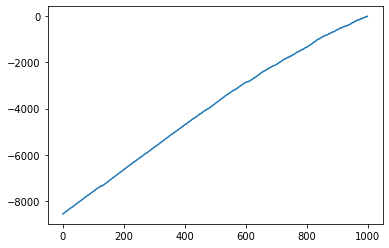

In [29]:
score = lr.predict_proba(X_test)

idx=np.argsort(score[:,1])

balance_old = -1e10 
max_idx  = 0
b = []
for i in idx:
    yhat = np.where(score[:,1]>score[i,1],1.0,0.0)
    TP = np.sum(np.logical_and(yhat==y_test,yhat==1.))
    TN = np.sum(np.logical_and(yhat==y_test,yhat==0.))
    FP = np.sum(np.logical_and(yhat!=y_test,yhat==1.))
    FN = np.sum(np.logical_and(yhat!=y_test,yhat==0.))
    alpha = 10
    beta = 0.1
    balance=-alpha*(TP+FP)+beta*TP*100
    
    b.append(balance)
    
    if balance > balance_old:
        max_idx = i
        balance_old = balance
    
plt.plot(np.array(b))
score[max_idx,1]
yhat = np.where(score[:,1]>score[max_idx,1],1.0,0.0)
print (metrics.confusion_matrix(yhat,y_test))

Another way of addressing this problem is by assigning weights to the classes. Let us check it.

In [30]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(class_weight={1:0.0001})

lr.fit(X_train,y_train)

yhat = lr.predict(X_test)

from sklearn import metrics

c = metrics.confusion_matrix(yhat,y_test)


print (c)

[[857 143]
 [  0   0]]


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[857 142]
 [  0   1]]


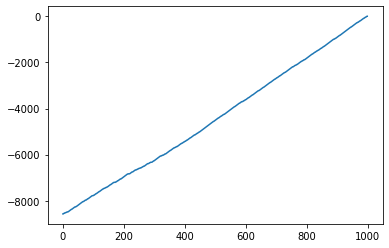

In [31]:
score = lr.predict_proba(X_test)

idx=np.argsort(score[:,1])

balance_old = -1e10 
max_idx  = 0
b = []
for i in idx:
    yhat = np.where(score[:,1]>score[i,1],1.0,0.0)
    TP = np.sum(np.logical_and(yhat==y_test,yhat==1.))
    TN = np.sum(np.logical_and(yhat==y_test,yhat==0.))
    FP = np.sum(np.logical_and(yhat!=y_test,yhat==1.))
    FN = np.sum(np.logical_and(yhat!=y_test,yhat==0.))
    alpha = 10
    beta = 0.1
    balance=-alpha*(TP+FP)+beta*TP*100
    
    b.append(balance)
    
    if balance > balance_old:
        max_idx = i
        balance_old = balance
    
plt.plot(np.array(b))
score[max_idx,1]
yhat = np.where(score[:,1]>score[max_idx,1],1.0,0.0)
print (metrics.confusion_matrix(yhat,y_test))

Selecting the best weight and model can be troublesome. Let us introduce our last methodology. We may use model selection checking for the parameters. There are different ways for doing so. The most well known is grid search on the parameters.

In [34]:
from sklearn import svm
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

parameters = {'class_weight' : [{1:0.01},{1:0.1},{1:1},{1:10},{1:100}], 'C':[0.01,0.1,1.,10.,100.]}

kf=model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.LinearSVC()
    # We can change the scoring "average_precision", "recall", "f1"
    clf = model_selection.GridSearchCV(clf, parameters, scoring='precision_macro')
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    #recall, f1, precision
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    print (str(clf.best_params_))
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

{'C': 0.01, 'class_weight': {1: 1}}


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

{'C': 1.0, 'class_weight': {1: 1}}


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-pack

{'C': 0.01, 'class_weight': {1: 1}}


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-pack

{'C': 0.1, 'class_weight': {1: 1}}


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-pack

{'C': 10.0, 'class_weight': {1: 1}}
Mean accuracy: 0.8604832718775747


/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/volokin/PythonEnvs/ds-3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [35]:
metrics.confusion_matrix(yhat,y)

array([[2797,  412],
       [  53,   71]])

In [36]:
print (metrics.classification_report(y,yhat))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2850
           1       0.57      0.15      0.23       483

    accuracy                           0.86      3333
   macro avg       0.72      0.56      0.58      3333
weighted avg       0.83      0.86      0.82      3333



<div class = "alert alert-danger" style = "border-radius:10px">**DELIVERABLE: ** Next day we will work on the problem of `Churn?`. Report the best classifier found and their metrics.
<p>
Some hints
<ol>
<li>Select one or two classifiers. Some of the most powerful classifiers are `Random Forests`, `SVM with RBF kernel`, and `extreme Gradient Boosting`.</li>
<li>Find out what parameters to validate. </li>
<li>Grid search and cross validate the problem.</li>
</ol>
</div>